# Laboratorio 3: Word Embeddings

- Profesores: [Andrés Abeliuk](https://aabeliuk.github.io/), [Fabián Villena](https://villena.cl/).
- Profesor Auxiliar: [Martín Paredes](https://github.com/MartinParedesR/)


In [1]:
!pip install datasets
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 68.1 MB/s eta 0:00:00


In [2]:
import datasets
import numpy as np
import pandas as pd
# import spacy.lang.es
import matplotlib.pyplot as plt
import sklearn.pipeline
import sklearn.feature_extraction

# Word Embeddings: Word2Vec

### El gran problema de Bag of Words

Pensemos en estas 3 frases como documentos:

- $doc_1$: `¡Buenísima la marraqueta!`
- $doc_2$: `¡Estuvo espectacular ese pan francés!`
- $doc_3$: `!Buenísima esa pintura!`

Sabemos $doc_1$ y $doc_2$ hablan de lo mismo y que $doc_3$  no tiene mucho que ver con los otros.

**¿Cuál es el problema?**

`buenísima` $\begin{bmatrix}1 \\ 0 \\ 0 \\ 0 \\ 0 \\0\end{bmatrix}$ y `espectacular` $ \begin{bmatrix}0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0\end{bmatrix}$ representan ideas muy similares. Por otra parte, sabemos que `marraqueta` $\begin{bmatrix}0 \\ 1 \\ 0 \\ 0 \\ 0 \\0\end{bmatrix}$ y `pan francés` $\begin{bmatrix}0 \\ 0 \\ 0 \\ 0 \\ 1 \\0\end{bmatrix}$ se refieren al mismo objeto. Pero en este modelo, estos **son totalmente distintos**. Es decir, los vectores de las palabras que `buenísima` y `espectacular` son tan distintas como `marraqueta` y `pan francés`. Esto se debe a que cada palabra ocupa una dimensión distinta a las demás y son completamente independientes. Esto evidentemente, repercute en la calidad de los modelos que creamos a partir de nuestro Bag of Words.

Nos gustaría que eso no sucediera. Que existiera algún método que nos permitiera hacer que palabras similares tengan representaciones similares

### **Word Embeddings**

Es una de las representaciones más populares del vocabulario de un corpus. La idea principal de los Word Embeddings es crear representaciones vectoriales densas y de baja dimensionalidad $(d << |V|)$ de las palabras a partir de su contexto.

Volvamos a nuestro ejemplo anterior: `buenísima` y `espectacular` ocurren muchas veces en el mismo contexto, por lo que los embeddings que los representan debiesen ser muy similares... (*ejemplos de mentira hechos a mano*):

`buenísima` $\begin{bmatrix}0.32 \\ 0.44 \\ 0.92 \\ .001 \end{bmatrix}$ y `espectacular` $\begin{bmatrix}0.30 \\ 0.50 \\ 0.92 \\ .002 \end{bmatrix}$ versus `marraqueta`  $\begin{bmatrix}0.77 \\ 0.99 \\ 0.004 \\ .1 \end{bmatrix}$ el cuál es claramente distinto.

## **Entrenar nuestros Embeddings**

Para entrenar nuestros embeddings, usaremos el paquete gensim. Este trae una muy buena implementación de `word2vec`.




In [3]:
import re
import pandas as pd
from time import time
from collections import defaultdict
import string
import multiprocessing
import os
import requests
import numpy as np

# word2vec
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phrases, Phraser

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# scikit-learn
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

# visualizaciones
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets

In [4]:
# Obtener stopwords en español

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stopwords_es = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Cargar el dataset y limpiar

Utilizaremos un datos de diversas fuentes de noticias que cuenta con tres atributos principales:

* texto: Referente al texto de la noticia.
* medio: Referente al medio de la noticia.
* fecha: Referente a la fecha de publicación.

In [5]:
dataset = pd.read_csv('https://raw.githubusercontent.com/giturra/JCC2023-WE/main/noticias_oct_dic_2019.tsv', sep='\t')

dataset.head()

,texto,medio,fecha
0,Rey de Tailandia despoja de títulos a su conso...,El Mercurio,2019-10-21 14:51:00
1,Denuncian que personas con epilepsia sufrieron...,El Mercurio,2019-12-18 12:12:00
2,Índice victimización de hogares en el país suf...,El Mercurio,2019-10-15 09:58:00
3,"Meditación, cocina, jardinería, manualidades: ...",El Mercurio,2019-11-16 16:42:00
4,Director de empresa que procesa datos electora...,El Mercurio,2019-11-01 05:25:00


In [6]:
dataset.medio.unique()

array(['El Mercurio', 'Cooperativa CL', 'CHV', 'MEGA', 'La Discusión',
       'El Rancaguino', 'La Nación', 'Radio Concierto', 'The Clinic',
       'La RED'], dtype=object)

In [7]:
from collections import Counter

# limpiar puntuaciones y separar por tokens.
punctuation = string.punctuation + "«»“”‘’…—"
stopwords = stopwords_es

def simple_tokenizer(doc, lower=False):
    if lower:
        tokenized_doc = doc.translate(str.maketrans(
            '', '', punctuation)).lower().split()

    tokenized_doc = doc.translate(str.maketrans('', '', punctuation)).split()
    tokenized_doc = [
        token for token in tokenized_doc if token.lower() not in stopwords
    ]
    return tokenized_doc

content = dataset['texto']
cleaned_content = [simple_tokenizer(doc,lower=True) for doc in content.values]

In [8]:
dataset.texto[10]

'El clásico Aston Martin DB5 de James Bond llega armado hasta los dientes en la película "No time to die"\n\nDefinitivamente la nueva película de James Bond encendió motores este miércoles al liberar su primer trailer antes de su estreno programado para abril de 2020 y donde se pudo apreciar al legendario Aston Martin DB5 más rudo que nunca y armado hasta los dientes con dos poderosas ametralladoras Gatling.\nHasta ahora lo único que se sabía de esta producción cinematográfica, que marca el término del actor Daniel Craig como el agente 007, es que reunirá en la misma historia a cuatro de los modelos más espectaculares que han salido de la línea de producción de fabricante de autos británico.\n\n(Aston Martin DB5)\nAdemás del icónico DB5, que debutó junto al seductor espía en la cinta “Goldfinger” de 1964, también dirán presentes en la pantalla grande los Aston Martin V8 Vantage, DBS Superleggera y el Valhalla.\nRespecto de las primeras imágenes que hoy se conocieron de la nueva cinta d

In [9]:
print("Ejemplo de alguna noticia: {}".format(cleaned_content[10]))
# print("noticia original: {}".format(content[10]))

Ejemplo de alguna noticia: ['clásico', 'Aston', 'Martin', 'DB5', 'James', 'Bond', 'llega', 'armado', 'dientes', 'película', 'time', 'to', 'die', 'Definitivamente', 'nueva', 'película', 'James', 'Bond', 'encendió', 'motores', 'miércoles', 'liberar', 'primer', 'trailer', 'estreno', 'programado', 'abril', '2020', 'pudo', 'apreciar', 'legendario', 'Aston', 'Martin', 'DB5', 'rudo', 'nunca', 'armado', 'dientes', 'dos', 'poderosas', 'ametralladoras', 'Gatling', 'ahora', 'único', 'sabía', 'producción', 'cinematográfica', 'marca', 'término', 'actor', 'Daniel', 'Craig', 'agente', '007', 'reunirá', 'misma', 'historia', 'cuatro', 'modelos', 'espectaculares', 'salido', 'línea', 'producción', 'fabricante', 'autos', 'británico', 'Aston', 'Martin', 'DB5', 'Además', 'icónico', 'DB5', 'debutó', 'junto', 'seductor', 'espía', 'cinta', 'Goldfinger', '1964', 'dirán', 'presentes', 'pantalla', 'grande', 'Aston', 'Martin', 'V8', 'Vantage', 'DBS', 'Superleggera', 'Valhalla', 'Respecto', 'primeras', 'imágenes', 

### Extracción de Frases

Para crear buenas representaciones, es necesario tambien encontrar conjuntos de palabras que por si solas no tengan mayor significado (como `nueva` y `york`), pero que juntas que representen ideas concretas (`nueva york`).

Para esto, usaremos el primer conjunto de herramientas de `gensim`: `Phrases` y `Phraser`.

In [10]:
# Phrases recibe una lista de oraciones, y junta bigramas que estén al menos 100 veces repetidos
# como un único token. Detrás de esto hay un modelo estadístico basado en frecuencias, probabilidades, etc
# pero en términos simples ese es el resultado

phrases = Phrases(cleaned_content, min_count=100)

In [11]:
def top_bigrams_from_phrases(phrases, top=20):
    """
    Extrae los bigramas aprendidos por gensim.models.Phrases
    y los retorna ordenados por frecuencia (desc).
    """
    bigrams = {}
    for k, v in phrases.vocab.items():
        # Filtra verdaderos bigramas (contienen al menos un "_" )
        # y evita tokens vacíos/raros
        if "_" in k and len(k) > 1:
            bigrams[k] = v

    # Ordena por frecuencia descendente
    return sorted(bigrams.items(), key=lambda x: -x[1])[:top]

# Uso:
tops = top_bigrams_from_phrases(phrases, top=20)
for bg, freq in tops:
    print(bg, freq)


The_Clinic 1395
2019_The 1271
redes_sociales 1079
puedes_ver 878
estallido_social 814
Sebastián_Piñera 711
Temas_Deportes 709
Colo_Colo 684
Derechos_Humanos 670
Noviembre_2019 635
derechos_humanos 608
Octubre_2019 580
Fútbol_Fútbol 538
crisis_social 512
nueva_Constitución 510
Trend_noticias 497
Universidad_Chile 468
¿Qué_pasó 463
toque_queda 445
Copa_Libertadores 442


Ahora, usamos `Phraser` para re-tokenizamos el corpus con los bigramas encontrados. Es decir, juntamos los tokens separados que detectamos como frases.

In [12]:
bigram = Phraser(phrases)
sentences = bigram[cleaned_content]

In [13]:
sentences[2]

['Índice',
 'victimización',
 'hogares',
 'país',
 'sufre',
 'fuerte',
 'alza',
 '406',
 'porcentaje',
 'temor',
 'alto',
 'familias',
 'casi',
 'duplicó',
 'índice',
 'victimización',
 'entrega',
 'fundación',
 'Paz',
 'Ciudadana',
 'sufrió',
 'fuerte',
 'alza',
 'respecto',
 'medición',
 'año_pasado',
 'acuerdo',
 'informe',
 'porcentaje',
 'hogares',
 'integrantes',
 'víctima',
 'robo',
 'intento',
 'robo',
 'últimos',
 'seis',
 'meses',
 'alcanzó',
 '406',
 'subiendo',
 '42',
 'puntos',
 'relación',
 '2018',
 'trata',
 'mayor',
 'nivel',
 '2014',
 'indicador',
 'ubicó',
 '435',
 'ver',
 'gráfico',
 'abajo',
 'porcentaje',
 'hogares',
 'algún',
 'miembro',
 'familia',
 'sido',
 'víctima',
 'mayor',
 'Santiago',
 '45',
 'regiones',
 '335',
 'diferencia',
 'acrecienta',
 'respecto',
 'año',
 'anterior',
 '392',
 '318',
 'respectivamente',
 'Además',
 'porcentaje',
 'robos',
 'intentos',
 'robo',
 'ocurre',
 'vía',
 'pública',
 'mantenido',
 'constante',
 'últimos',
 'años',
 '846',
 '

### Ejercicio 1: Definir el modelo



Primero, como es usual, creamos el modelo. En este caso, usaremos uno de los primero modelos de embeddings neuronales: `word2vec`

Algunos parámetros importantes:

- `min_count`: Ignora todas las palabras que tengan frecuencia menor a la indicada.
- `window` : Tamaño de la ventana. Usaremos 4.
- `size` : El tamaño de los embeddings que crearemos. Por lo general, el rendimiento sube cuando se usan mas dimensiones, pero después de 300 ya no se nota cambio. Ahora, usaremos solo 200.
- `(Recomendable) workers`: Cantidad de CPU que serán utilizadas en el entrenamiento.

In [27]:
#Programe aquí
w2v = Word2Vec(sentences= sentences, min_count=10,
                window=4,
                vector_size=200,
                sample=6e-5,
                alpha=0.03,
                min_alpha=0.0007,
                negative=20,
                workers=multiprocessing.cpu_count())

### Entrenar el modelo -- Importante

Al definir el modelo de `Word2Vec` si se le entregan directamente los datos, se contruye inmediatamente el vocabulario y se entrena el modelo para obtener los `word embeddings` de los textos. Sin embargo estos 2 pasos también se pueden realizar de forma explícita para obtener un mayor control de los hiperparámetros.

### Construir el vocabulario

Para esto, se creará un conjunto que contendrá (una sola vez) todas aquellas palabras que aparecen mas de `min_count` veces.

In [33]:
w2v.build_vocab(sentences, progress_per=10000)

### Ejercicio 2: Entrenar el Modelo

A continuación, entenaremos el modelo.
Los parámetros que usaremos serán:

- `total_examples`: Número de documentos.
- `epochs`: Número de veces que se iterará sobre el corpus.

Es recomendable que tengan instalado `cpython` antes de continuar. Aumenta bastante la velocidad de entrenamiento.


In [34]:
t = time()
w2v.train(sentences, total_examples=w2v.corpus_count, epochs=20, report_delay=0) # report_delay=0 reports at the end of each epoch
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 2.48 mins


###  Guardar y cargar el modelo

Para ahorrar tiempo (o se espera que se entrene el modelo), usaremos un modelo preentrenado.

In [35]:
kv = w2v.wv
kv.save("w2v.kv")
kv = KeyedVectors.load("w2v.kv", mmap='r')  # mapea a disco, menos RAM
kv.fill_norms()  # opcional, acelera similarity/most_similar

### Ejercicio 3: Analogías

Encuentre las palabras mas similares a: perro, Chile y Colo_Colo

In [36]:
kv.most_similar(positive=["perro"])

[('callejero', 0.6928277611732483),
 ('can', 0.6371320486068726),
 ('coyote', 0.6293607354164124),
 ('gato', 0.6173743605613708),
 ('Pikachu', 0.607256293296814),
 ('vestido', 0.6008550524711609),
 ('traje', 0.5977185964584351),
 ('visiblemente', 0.5960575342178345),
 ('Perro', 0.5918106436729431),
 ('Matapacos', 0.5908935070037842)]

In [37]:
kv.most_similar(positive=["Chile"])

[('país', 0.5450892448425293),
 ('oasis', 0.4329044818878174),
 ('sociopolítica', 0.41546788811683655),
 ('políticosocial', 0.4026358127593994),
 ('América_Latina', 0.397932231426239),
 ('acontecimientos', 0.39355194568634033),
 ('UNHumanRights', 0.39148011803627014),
 ('convulsionada', 0.3881385326385498),
 ('Argentina', 0.3809293806552887),
 ('Canciller', 0.35792702436447144)]

In [38]:
kv.most_similar(positive=["Colo_Colo"])

[('Cacique', 0.735996425151825),
 ('0010', 0.6937875151634216),
 ('superclásico', 0.6928467154502869),
 ('albos', 0.6868862509727478),
 ('Superclásico', 0.6640331149101257),
 ('Pajarito', 0.6480862498283386),
 ('UC', 0.6370930671691895),
 ('Esteban_Paredes', 0.6370468139648438),
 ('Mosa', 0.6348204016685486),
 ('Carlo', 0.6280950307846069)]

Por otra parte, la analogía consiste en comparar 3 terminos mediante una operación del estilo:

$$palabra1 - palabra2 \approx palabra 3 - x$$

para encontrar relaciones entre estos.

Por ejemplo: **Sol** es a **Día** como **Luna** es a **x**.

Lo cual se puede representar de esta forma:

| palabra 1 (pos) |  palabra 2 (neg) |
|-----------------|------------------|
|  Sol          | Día         |
| Luna           |  x               |

En donde **x** corresponde a **Noche**.

Usando el modelo entrenado encuentre la respuesta a las siguientes analogías:

- Brasil es a Bolsonaro como Argentina es a **?**
- Santiago es a Chile como Buenos Aires es a **?**

In [41]:
kv.most_similar(positive=["Bolsonaro", "Argentina" ], negative=['Brasil'], topn=10)

[('Jair', 0.6007896065711975),
 ('Alberto_Fernández', 0.5981394052505493),
 ('juró', 0.5560281872749329),
 ('electo', 0.5398353338241577),
 ('asunción', 0.5210694670677185),
 ('Kirchner', 0.5199359655380249),
 ('peronista', 0.5140998363494873),
 ('saliente', 0.49110445380210876),
 ('Cristina', 0.4770415127277374),
 ('20072015', 0.4656510055065155)]

In [42]:
kv.most_similar(positive=[ "Buenos_Aires", "Chile", ], negative=['Santiago'], topn=10)

[('Argentina', 0.5392186641693115),
 ('Honduras', 0.4552918076515198),
 ('Miss', 0.43079736828804016),
 ('Latinoamérica', 0.4165433645248413),
 ('México', 0.41515862941741943),
 ('asilado', 0.4148402512073517),
 ('Guatemala', 0.4066285789012909),
 ('latinoamericanos', 0.4017694592475891),
 ('expulsó', 0.38766735792160034),
 ('sudamericana', 0.3856920003890991)]

### Ejercicio 4: Visualizar

Para visualizar usaremos las 1000 palabras más comunes y reduciremos las 200 dimensiones a 2. Para esto, grafique un [`T-SNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.352471
[t-SNE] KL divergence after 50 iterations with early exaggeration: 70.342079
[t-SNE] KL divergence after 1000 iterations: 1.504309


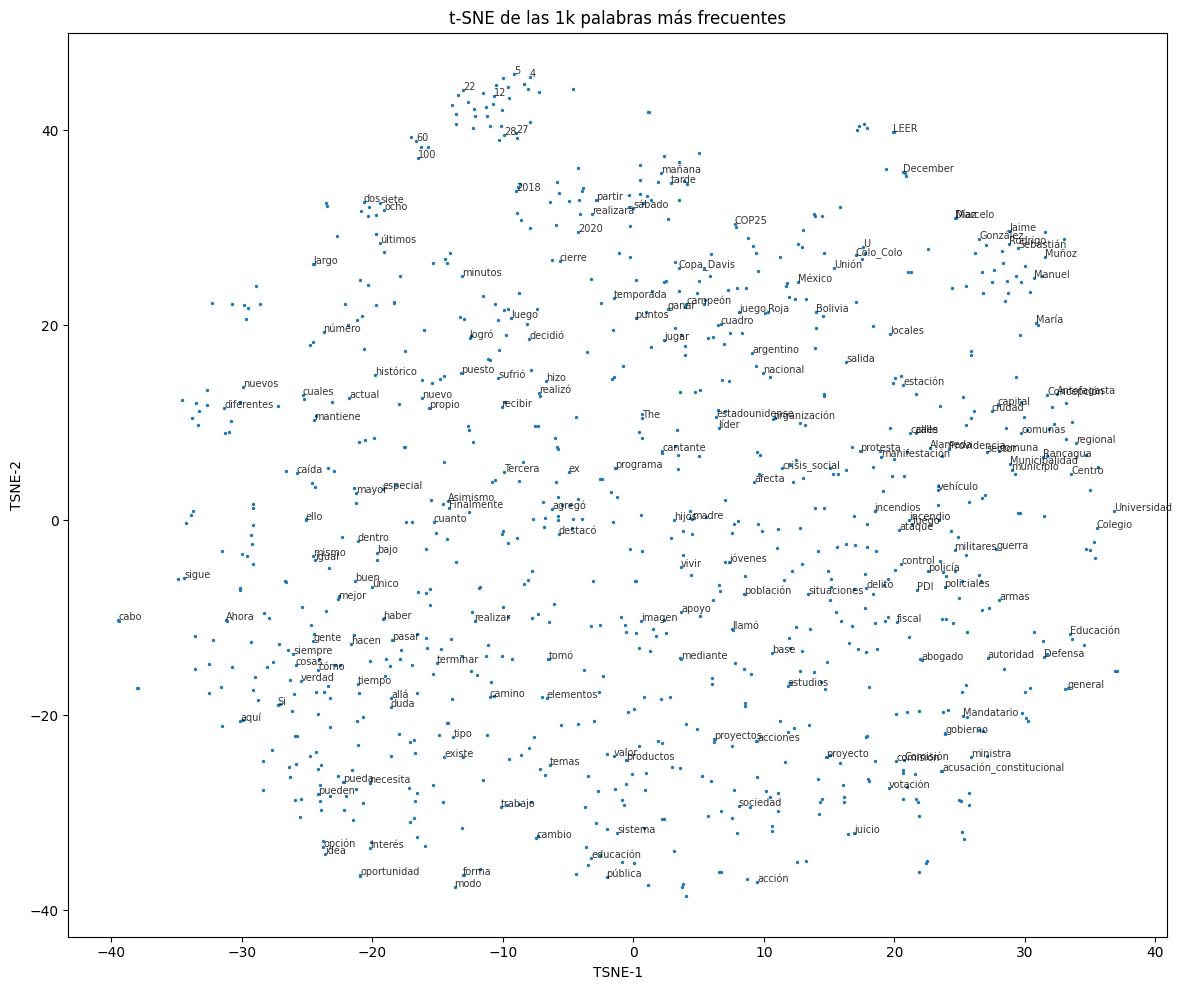

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 1) Tomamos las 1k palabras más frecuentes
kv = w2v.wv  # KeyedVectors
top_n = 1000
words = kv.index_to_key[:top_n]              # ordenadas por frecuencia
X = kv.get_normed_vectors()[:top_n]          # (1k, 200) ya normalizados L2

# 2) t-SNE a 2D
tsne = TSNE(
    n_components=2,
    init="pca",            # inicia con PCA (suele converger mejor)
    perplexity=30,         # si top_n es muy grande y/o corpus diverso, puedes subir a 40-50
    learning_rate="auto",
    n_iter=1000,
    random_state=42,
    verbose=1,
    method="barnes_hut",   # eficiente para 2D
)
emb_2d = tsne.fit_transform(X)            # shape: (1k, 2)

# 4) Gráfico básico (sin colorear, para evitar ruido visual)
plt.figure(figsize=(12, 10))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=2)
plt.title("t-SNE de las 1k palabras más frecuentes")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")

# 5) Etiquetar solo una muestra (p. ej., 200) para no saturar
rng = np.random.default_rng(42)
idx_sample = rng.choice(len(words), size=min(200, len(words)), replace=False)
for i in idx_sample:
    plt.annotate(words[i], (emb_2d[i, 0], emb_2d[i, 1]), fontsize=7, alpha=0.8)

plt.tight_layout()
plt.show()

Se espera que el gráfico tenga esta forma:

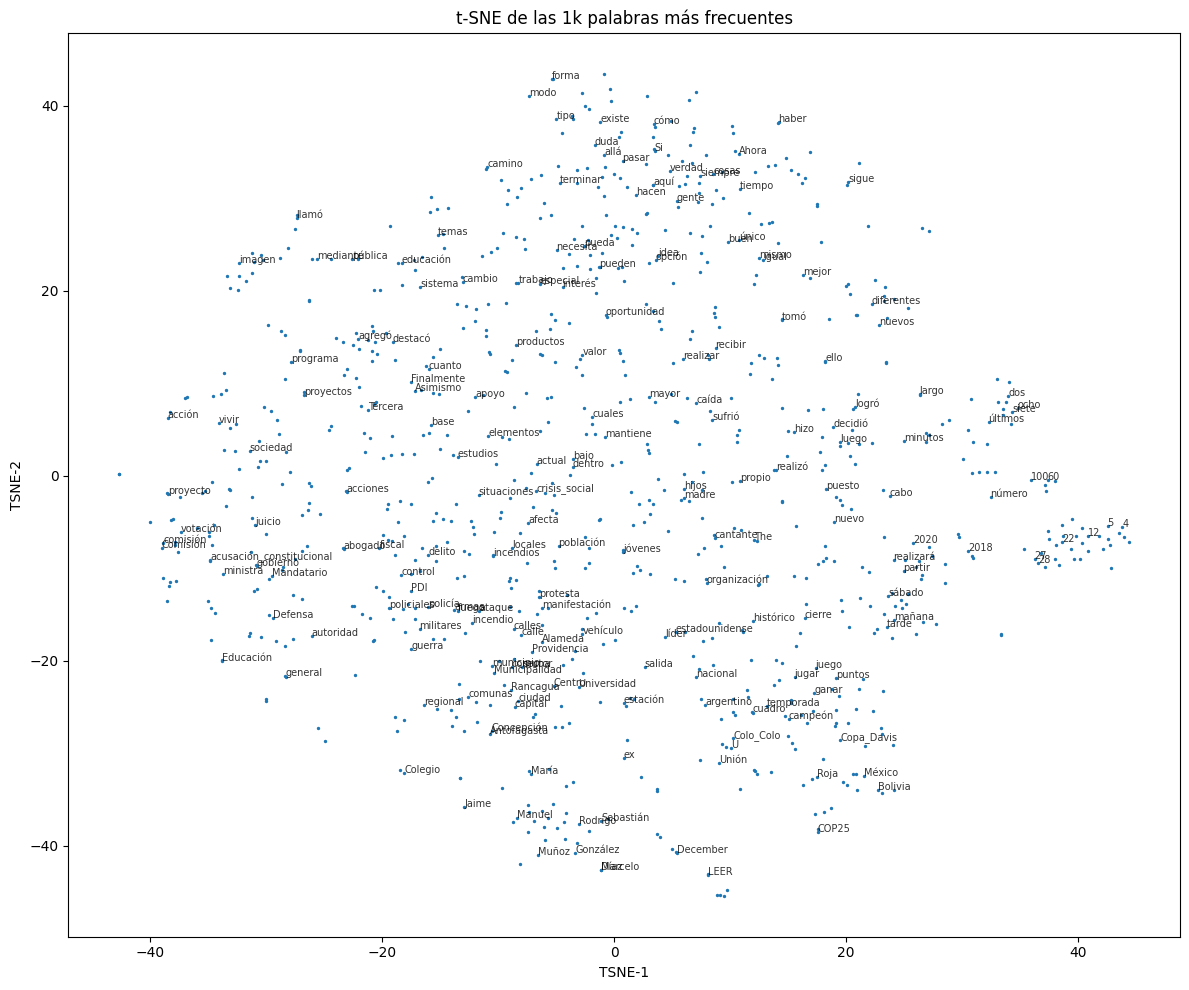

## **Ejercicio 5: Word Embeddings como características para recuperación semántica**


En esta sección usaremos word embeddings como representación para recuperar noticias por significado (no solo por palabras exactas). La idea es convertir tanto las consultas como las noticias en vectores y buscar por similitud en ese espacio.
Ejemplo: si el usuario escribe “deporte”, la búsqueda semántica también podrá traer artículos titulados “Liga profesional”, “Final del torneo”, “Selección nacional” o “Atleta olímpico clasifica”, aunque no contengan literalmente la palabra “deporte”.

El objetivo de esta sección es comparar como afectan distintas representaciones de texto a la hora de realizar recuperación semántica.

Para realizar la recuperación semántica programe la función que se muestra a continuación, la obtiene el **vector promedio** de las representaciones de la palabra en un documento.

Luego obtenga diferentes representaciones del texto usando tf-idf y word2vec. Con ambas representaciones Compare los top-k documentos más similares a la query del texto **deporte** usando la función entregada y luego compare. ¿Cómo difieren los top-k documentos entre sí? ¿Por qué? ¿Cómo afecta el uso de distintos embeddings para un mismo problema?


#### Obtener representaciones del texto tf-idf y word2vec

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Representación TF-IDF pura
# Necesitamos convertir los tokens de vuelta a strings para el TfidfVectorizer
cleaned_content_str = [" ".join(tokens) for tokens in cleaned_content]

# Inicializar y ajustar el TfidfVectorizer
# También aplicamos las stop words aquí.
# (Opcional) min_df=10 para ignorar términos que aparecen en menos de 10 documentos (similar a min_count en Word2Vec)
tfidf_vectorizer = TfidfVectorizer(tokenizer=simple_tokenizer, stop_words=stopwords_es, min_df=10, lowercase=True)

# Ajustar y transformar los datos para obtener la representación TF-IDF pura
D_tfidf = tfidf_vectorizer.fit_transform(cleaned_content_str)

print("Representaciones TF-IDF pura obtenidas. Shape:", D_tfidf.shape)

# 2. Representación promedio simple de Word2Vec
def doc_embed_mean(tokens, kv):
    vecs = [kv[w] for w in tokens if w in kv.key_to_index]
    if not vecs:
        return np.zeros(kv.vector_size, dtype=np.float32)
    v = np.mean(vecs, axis=0)
    # Normaliza (opcional)
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

D_mean = np.vstack([doc_embed_mean(toks, kv) for toks in cleaned_content])

print("Representaciones promedio simple de Word2Vec (D_mean). Shape:", D_mean.shape)

Representaciones TF-IDF pura obtenidas. Shape: (10000, 15546)
Representaciones promedio simple de Word2Vec (D_mean). Shape: (10000, 200)


#### Obtener top-k documentos más similares

In [58]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_top_k(query_vec, D_matrix, original_texts, k=5):
    """
    Devuelve top-k documentos más similares a la query usando coseno
    entre el vector de consulta y la matriz de documentos.
    """
    # 1. Calculate cosine similarity between query embedding and document embeddings
    # D_matrix is already normalized (or should be for meaningful cosine similarity)
    # query_vec should also be normalized
    query_vec_normalized = query_vec / np.linalg.norm(query_vec)
    if np.linalg.norm(query_vec_normalized) == 0:
         # Handle case where query results in zero vector
        return pd.DataFrame(columns=["rank", "doc_id", "score", "snippet"])


    sims = cosine_similarity(query_vec_normalized.reshape(1, -1), D_matrix).ravel()  # shape: (n_docs,)

    # 2. Get top-k indices and scores
    idx = np.argsort(-sims)[:k]

    # 3. Return results as a DataFrame
    return pd.DataFrame({
        "rank": np.arange(1, len(idx)+1),
        "doc_id": idx,
        "score": sims[idx],
        "snippet": [original_texts[i][:160].replace("\n"," ") + ("..." if len(original_texts[i])>160 else "") for i in idx]
    })

In [62]:
"""
Compara los top-k documentos más similares a la query usando coseno
con embeddings promedio simple y representaciones TF-IDF.
"""
# Ejemplo de uso:
query = "deporte"  # Puedes cambiar esta consulta

# --- 1. Obtener vector de consulta para TF-IDF ---
# Tokenizar la consulta
query_tokens = simple_tokenizer(query, lower=True)
# Transformar la consulta usando el vectorizador TF-IDF entrenado con el corpus
# Necesitamos que la consulta sea una lista de strings para el transform
query_str = " ".join(query_tokens)
query_vec_tfidf = tfidf_vectorizer.transform([query_str]) # transform espera un iterable

# D_tfidf es una matriz dispersa, por lo que query_vec_tfidf también es dispersa.
# retrieve_top_k espera un vector denso para la consulta, y maneja D_matrix dispersa.
# Verificamos que retrieve_top_k use cosine_similarity, que maneja entrada dispersa.
# Sin embargo, query_vec se reformatea y normaliza, asegurémonos de que sea denso para eso.

# --- 2. Obtener vector de consulta para Promedio Simple (Word2Vec) ---
# Obtener el vector promedio de Word2Vec para los tokens de la consulta
query_vec_mean_w2v = doc_embed_mean(query_tokens, kv)


print(f"Query: '{query}'")

print("\n=== Representaciones TF-IDF: top-k ===")
# retrieve_top_k espera vector de consulta denso, D_tfidf es dispersa
# Convertimos query_vec_tfidf a denso
tfidf_res = retrieve_top_k(query_vec_tfidf.toarray().ravel(), D_tfidf, content, k=5)
print(tfidf_res.to_string())

print("\n=== Promedio Simple (Word2Vec): top-k ===")
# D_mean ya es densa, query_vec_mean_w2v es densa
mean_w2v_res = retrieve_top_k(query_vec_mean_w2v, D_mean, content, k=5)
print(mean_w2v_res.to_string())

# Ahora puedes comparar los resultados impresos y discutir las diferencias.

Query: 'deporte'

=== Representaciones TF-IDF: top-k ===
   rank  doc_id     score                                                                                                                                                              snippet
0     1    4801  0.457842  Cuestionan designación de Cecilia Pérez El deporte no quedó al margen del cambio de gabinete que realizó el Gobierno encabezado por el Presidente Sebastián Piñe...
1     2    6691  0.366273  Nicole “Luli” Moreno piensa postularse a alcaldesa en cinco años más La modelo Nicole “Luli” Moreno fue entrevistada en el matinal Bienvenidos de Canal 13, dond...
2     3    1055  0.351694  Ministra Kantor anunció la construcción de la Casa del Combate en el Estadio Nacional En el marco de la inversión en infraestructura para los Juegos Panamerican...
3     4    4549  0.314030  Designación de nueva seremi despierta críticas en el mundo deportivo La designación de la periodista Javiera Muñoz Carrasco, ex jefa de Gabinete y Comun

### Propuesto...

- Usar su modelo de embeddings favorito para ver si mejora el retrieval:
    
 - Fast y word2vec en español, [cortesía](https://github.com/dccuchile/spanish-word-embeddings) de los grandes del DCC

 - hacer un clasificador de noticias para predecir de que medio es

- Visualizar los documentos usando `doc2vec`